In [1]:
from qiskit import *
from qiskit import QuantumCircuit
from qiskit.quantum_info import Pauli, SparsePauliOp, Statevector
from qiskit.primitives import StatevectorEstimator
# from qiskit.opflow.state_fns import StateFn
# from qiskit.opflow import CircuitOp
# from qiskit.opflow.expectations import PauliExpectation
# from qiskit.opflow.converters import CircuitSampler
# from qiskit.opflow import CircuitStateFn
# from qiskit_aer import QasmSimulator
# from qiskit.circuit import Parameter
# from qiskit.utils import QuantumInstance
# from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
def mixer(beta,num_qubit):
    codeword = QuantumRegister(num_qubit,'codeword')
    
    recieved = QuantumRegister(num_qubit,'recieved')
    circ = QuantumCircuit(codeword,recieved)
    
    
    #circ.h(1)
  
    circ.rx(2*beta,1)

    #circ.h(1)

    
    circ.barrier()
    

    
    circ.barrier()
    return circ

In [3]:
def cost_unitary(gamma,num_qubit):
    codeword = QuantumRegister(num_qubit,'codeword')
    
    recieved = QuantumRegister(num_qubit,'recieved')
    
    circ = QuantumCircuit(codeword,recieved)
    for i in range(num_qubit):
        circ.cx(codeword[i],recieved[i])
        circ.rz((-gamma),recieved[i])
        circ.cx(codeword[i],recieved[i])
        circ.barrier()
    
    return circ

In [4]:
# gamma = Parameter("$\\gamma$") 

# beta = Parameter("$\\beta$")

def create_qaoa_circ(theta,num_qubit,p,r):
    
    beta = theta[0]
    gamma = theta[1]

    codeword = QuantumRegister(num_qubit,'codeword')
    recieved = QuantumRegister(num_qubit,'recieved')

    circ = QuantumCircuit(codeword,recieved)

    # if the codeword recieved is r = |0010>, in qiskit the 1 is in the 1st position of recieved register.
    
    for i in range(len(r)):
        if r[i] == '1':
            circ.x(recieved[i])
    
    circ.h(range(2))
    
    circ.cx(0,2)
    
    circ.barrier()
    
    for i in range(p):
        
        circ.append(mixer(beta,num_qubit),range(2*num_qubit))
        circ.append(cost_unitary(gamma,num_qubit),range(2*num_qubit))


    
    return circ

In [5]:
# Input parameters of the circuit was given as an array [beta and gamma].
# theta0 is beta and theta1 is gamma

def expectation(theta0,theta1):
    beta = theta0
    gamma = theta1
    
    psi = create_qaoa_circ([beta,gamma],num_qubit = 3,p = 3,r = '011')

    psi_sv = Statevector(psi)
    
    H = SparsePauliOp.from_list([
                                    ("IIIIII", 0.5),
                                    ("IIIIII", 0.5),
                                    ("IIIIII", 0.5),
                                    ("IIIIII", 0.5),
                                    ("ZIIZII", -0.5),
                                    ("IZIIZI", -0.5),
                                    ("IIZIIZ", -0.5)
                                ])

    estimator = StatevectorEstimator()
    
    result = estimator.run([(psi,[H])]).result()[0]
    
    return float(result.data.evs[0])

In [6]:
#         beta1, beta2,...
# gamma 1
# gamma 2
# .
# .
# .
# .

In [7]:
beta = np.arange(0.0,np.pi,0.05)
gamma = np.arange(0.0,2*np.pi,0.05)

x, y = np.meshgrid(beta,gamma)
f = np.vectorize(expectation)

z = f(x,y)

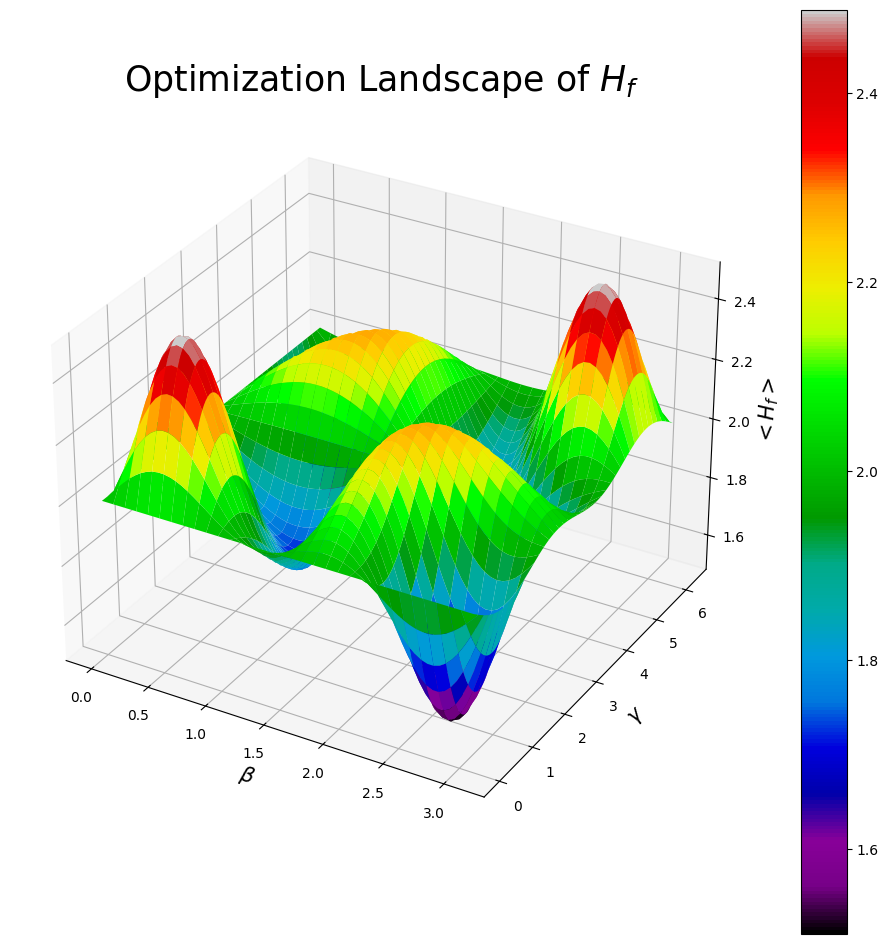

In [8]:
fig = plt.figure(figsize = (12,12))
ax = plt.axes(projection='3d')


# Creating color map
my_cmap = plt.get_cmap('nipy_spectral')          # 'nipy_spectral' 'hsv' 'turbo' 'hot''ocean' 'rainbow' twilight

surf = ax.plot_surface(x,y,z,cmap = my_cmap,
                       edgecolor ='none',shade = True)

#fig.colorbar(surf, ax, shrink=0.5, aspect=5)

# Set axes label
ax.set_xlabel("$\\beta$",fontsize = 15)
ax.set_ylabel("$\\gamma$",fontsize = 15)
ax.set_zlabel('$<H_f>$',fontsize = 15)
ax.set_title('Optimization Landscape of $H_f$',fontsize = 25)
fig.colorbar(surf)

plt.savefig('land321_300.png',dpi = 300)

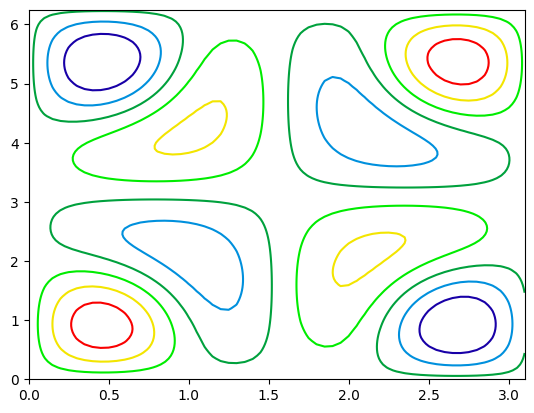

In [9]:
fig1 = plt.figure()
ax1 = plt.axes()
ax1.contour(x,y,z,cmap = 'nipy_spectral')
plt.show()

In [15]:
# Find the max length to standardize the size
max_length = max(len(beta), len(gamma), z.shape[0])

# Pad shorter arrays with NaN
beta_padded = np.pad(beta, (0, max_length - len(beta)), constant_values=np.nan)
gamma_padded = np.pad(gamma, (0, max_length - len(gamma)), constant_values=np.nan)
z_padded = np.pad(z, ((0, max_length - z.shape[0]), (0, 0)), constant_values=np.nan)

In [16]:
# Create a DataFrame
df = pd.DataFrame({
    "beta": beta_padded,
    "gamma": gamma_padded,
})

# Add z columns with formatted names
for i in range(z.shape[1]):  
    df[f"exp[beta{i}]"] = z_padded[:, i]

# Save to CSV
df.to_csv("land_321.csv", index=False)

In [22]:
gamma.shape

(126,)